In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
torch.cuda.is_available()

True

In [11]:

PANOS = False

In [26]:
# loading the data
from load_data import train_test_set_loader
# make datasets
train_test_set_loader(path="../output/", test_size=0.25, val_size=0.25 ,example=False, panos=PANOS)

Number of training images: 6420
Number of test images: 803
Number of validation images: 803
Images have been split into train, test, and validation sets.


In [3]:
# Location of data
datadir = ''
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 20

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [4]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df

,category,n_train,n_valid,n_test
1,london,1636,190,198
2,madrid,1601,194,205
3,moscow,1600,202,200
0,copenhagen,1583,217,200


<Axes: xlabel='category'>

(array([0, 1, 2, 3]),
 [Text(0, 0, 'london'),
  Text(1, 0, 'madrid'),
  Text(2, 0, 'moscow'),
  Text(3, 0, 'copenhagen')])

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

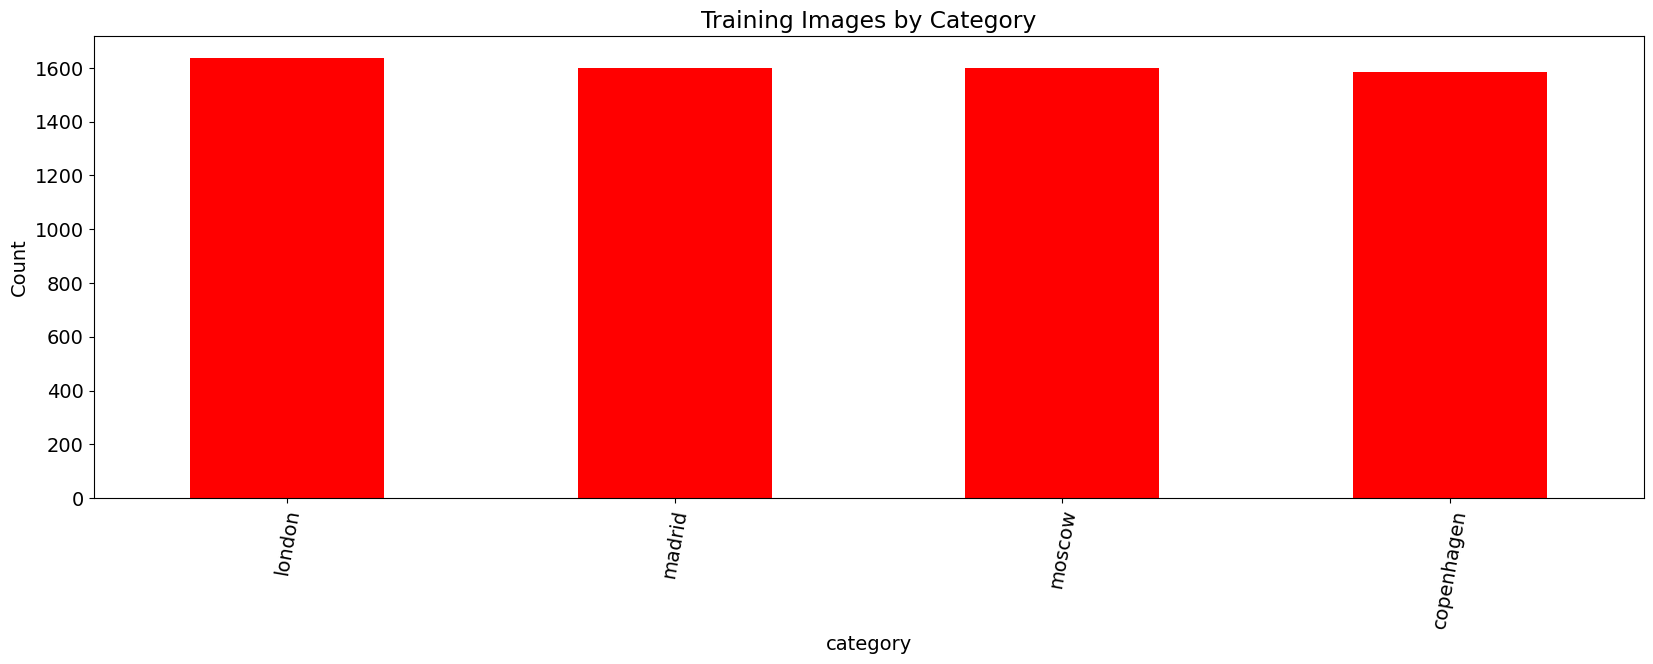

In [5]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

#### Distribution of Images Sizes

The images themselves have vastly different shapes. We can see this by looking at the stats of images sizes by category.

In [6]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                 width   
            count   mean  std    min    25%    50%    75%    max  count   
category                                                                  
copenhagen  311.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  311.0  \
london      318.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  318.0   
madrid      321.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  321.0   
moscow      330.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  330.0   

                                                           
             mean  std    min    25%    50%    75%    max  
category                                                   
copenhagen  640.0  0.0  640.0  640.0  640.0  640.0  640.0  
london      640.0  0.0  640.0  640.0  640.0  640.0  640.0  
madrid      640.0  0.0  640.0  640.0  640.0  640.0  640.0  
moscow      640.0  0.0  640.0  640.0  640.0  640.0  640.0

When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated. 

In [6]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Image Preprocessing

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image `transforms`, which prepare our data for a neural network.

### Data Augmentation

Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch `Tensor`s before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet. 

In [6]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=IMG_SIZE),
        # # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(),
        # transforms.RandomHorizontalFlip(),
        # # transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=IMG_SIZE),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=IMG_SIZE),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Examples of Augmentation

To show how augmentation works, we need to write a function that will plot a tensor as an image.

In [7]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

## Data Iterators

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`. 

One crucial aspect is to `shuffle` the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch). 

In [12]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=PANOS),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=PANOS),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=PANOS)
}

In [13]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([20, 3, 224, 224]), torch.Size([20]))

The shape of a batch is `(batch_size, color_channels, height, width)`. 

There should be 100 different classes. We can confirm this as follows.

In [14]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 4 different classes.


4

In [9]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The `classifier` is the part of the model that we'll train. However, for the vgg, we'll only need to train the last few layers in the classifier and not even all of the fully connected layers. 

### Freeze Early layers

We freeze all of the existing layers in the network by setting `requires_grad` to `False`. 

In [13]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [15]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=4, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

The final output will be log probabilities which we can then use in the Negative Log Likelihood Loss. 

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,404 total parameters.
135,310,404 training parameters.


Even with only a few layers set to trainable, there are still over a million parameters (weights) that will be updated during training. In effect, we are _fine-tuning_ the model to work on our problem. We already know it works well on Imagenet, and because our images are relatively similar, we should expect the model to easily _transfer_ its knowledge from Imagenet to our dataset.

### Move to GPU 

To use a gpu in PyTorch, we simply move the whole model onto the gpu. Later we'll have to move the data to gpus in our training loop.

Since I am using multiple gpus, I also distribute the model across both of them with `nn.DataParallel`. 

In [17]:
if train_on_gpu:
    print("using gpu")
    model = model.to('cuda')


using gpu


## Function to Load in Pretrained Model

We can refactor all that code into a single function that returns a pretrained model. This only accepts the vgg16 or resnet50 at the moment but can be extended to use other models. 

In [35]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1')

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

This should return the same as the pretrained model with the custom classifier. In the case of resnet, we replace the `fc` layers with the same classifier.

The `torchsummary` library has a helpful function called `summary` which summarizes our model.

In [54]:
model = get_pretrained_model('resnet50')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Juliu/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 56, 56]          16,384
      BatchNorm2d-14         [128, 256,

c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


We can see that the model is quite large and training all of the layers would take a considerable time. Even with only a few layers to train, this can still take a while to train. You might need to decrease the `batch_size` if this is not fitting on your gpu (hopefully you have one).

In [18]:
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
  (4): LogSoftmax(dim=1)
)


#### Mapping of Classes to Indexes

To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. This will let us know the actual class for a given prediction.

In [19]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'copenhagen'), (1, 'london'), (2, 'madrid'), (3, 'moscow')]

# Training Loss and Optimizer

The loss is the negative log likelihood and the optimizer is the Adam optimizer. The negative log likelihood in PyTorch expects log probabilities so we need to pass it the raw output from the log softmax in our model's final layer. The optimizer is told to optimizer the model parameters (only a few of which require a gradient). 

* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients 

In [20]:
# criterion = nn.NLLLoss() # for vgg16 (has logsoftmax activation function)
optimizer = optim.AdamW(model.parameters()) # for vgg16

criterion = nn.CrossEntropyLoss() # for ViT
optimizer = optim.AdamW(model.parameters()) # for ViT

Below we can look at the parameters (weights) that will be updated by the optimizer during training.

In [21]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([256, 4096])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


In [22]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            
            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [23]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=50,
    print_every=1)

Starting Training from Scratch.



OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 8.00 GiB total capacity; 6.89 GiB already allocated; 0 bytes free; 7.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

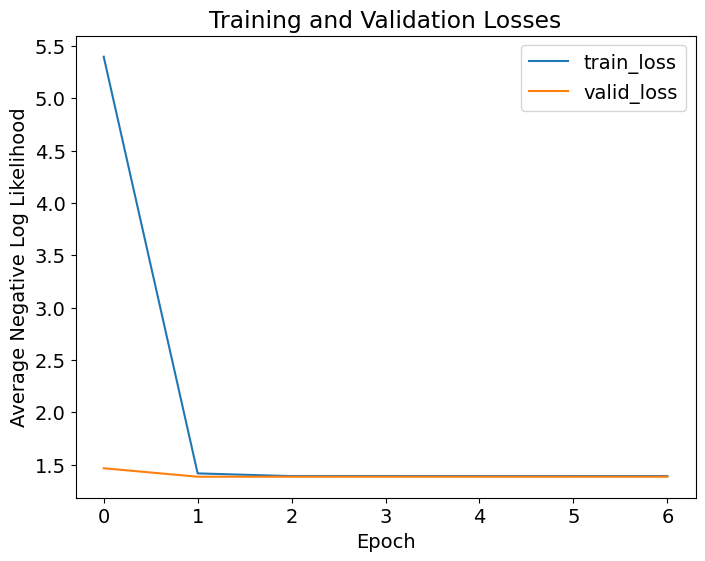

In [43]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

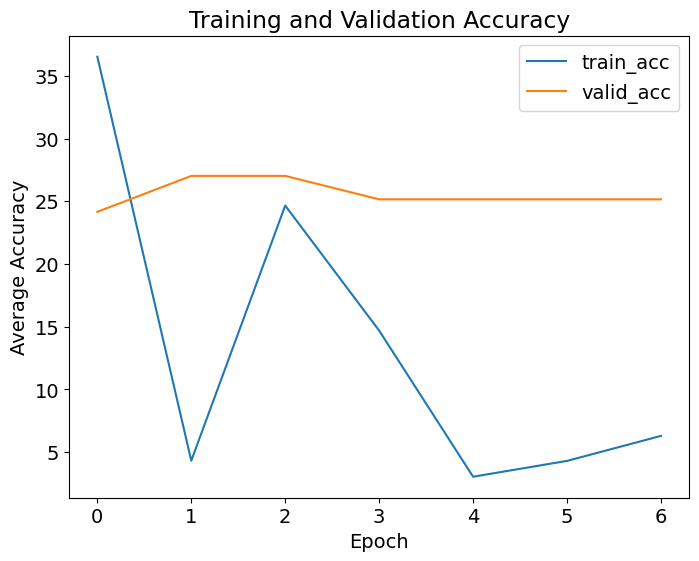

In [44]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

As with the losses, the training accuracy increases (nearly to perfect) while the validation accuracy plateaus. The model is able to achieve above 80% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.

# Saving Model

The `train` function saves the best model `state_dict()` which are the weights of the model. To save more information about the model, we use the below function. 

In [70]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [71]:
save_checkpoint(model, path=checkpoint_path)

In [72]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [73]:
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 256, 256), batch_size=batch_size)
else:
    summary(model, input_size=(3, 256, 256), batch_size=batch_size)

c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


135,310,404 total parameters.
1,049,860 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 2

c:\Users\Juliu\Desktop\REPOS\geocv\geocvenv\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


We can now use these two functions to save and load in a complete model. We can use this model to continue training. 

In [45]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 7 epochs.

Epoch: 1	100.00% complete. 75.39 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.3915 	Validation Loss: 1.3856
		Training Accuracy: 14.69%	 Validation Accuracy: 25.16%
Epoch: 3	100.00% complete. 75.57 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.3914 	Validation Loss: 1.3856
		Training Accuracy: 4.30%	 Validation Accuracy: 25.16%
Epoch: 5	100.00% complete. 75.10 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.3914 	Validation Loss: 1.3857
		Training Accuracy: 10.28%	 Validation Accuracy: 25.16%

Early Stopping! Total epochs: 5. Best epoch: 0 with loss: 1.39 and acc: 25.16%
506.50 total seconds elapsed. 84.42 seconds per epoch.
